In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5f0fbbb4d13463c4ceb81407f7f60bca3967ac7a789d100580979588e5a3ebed
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=affef0eee9e9f4bbc3be28a8e95b32ee68fcc8421047fd7753469590f05d32bd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

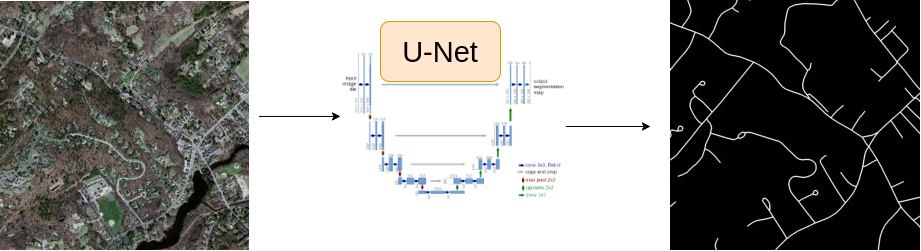

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [78]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [21]:
idx = 15

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

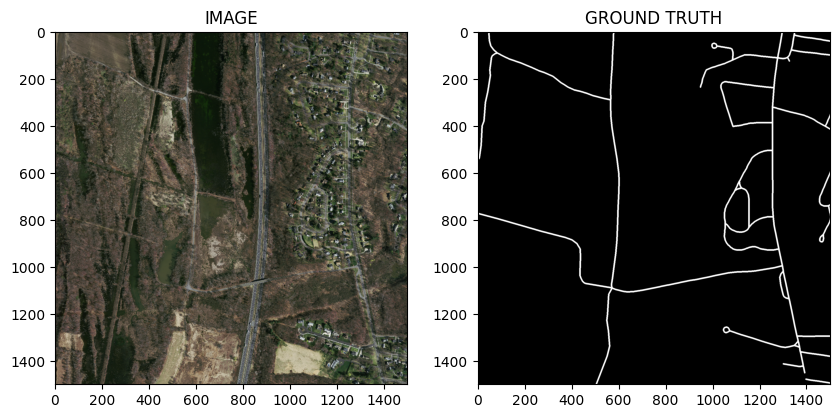

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [23]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [26]:
import albumentations as A

In [28]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [30]:
from torch.utils.data import Dataset

In [43]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [44]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [45]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


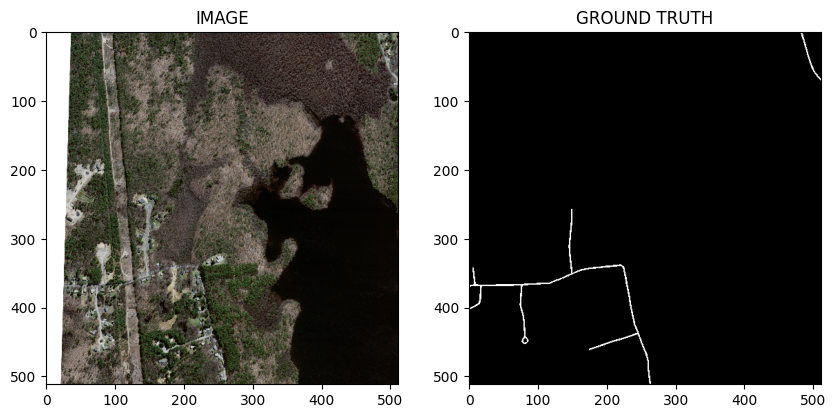

In [48]:
idx = 7
image, mask = trainset[idx]
helper.show_image(image, mask)

In [50]:
from torch.utils.data import DataLoader

In [52]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [53]:
print(f'Total no of batches in trainloader : {len(trainloader)}')
print(f'Total no of batches in validloader : {len(validloader)}')

Total no of batches in trainloader : 20
Total no of batches in validloader : 5


In [55]:
for images, masks in trainloader:
  print(f'One batch image shape: {images.shape}')
  print(f'One batch mask shape: {masks.shape}')
  break;

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


In [57]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [79]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits


In [81]:
model = SegmentationModel()
model.to(DEVICE);

In [82]:
def train_fn(dataloader, model, optimizer):

  model.train() # Turn on dropout, batchnorm, etc

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [83]:
def eval_fn(dataloader, model):

  model.eval() # Turn off dropout, batchnorm, etc

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [85]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'bestmodel.pt')
    print('MODEL SAVED')
    best_loss = valid_loss

    print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


MODEL SAVED
Epoch : 1 Train Loss : 1.2428958684206008 Valid Loss : 1.0278695583343507


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


MODEL SAVED
Epoch : 2 Train Loss : 0.7983226329088211 Valid Loss : 0.8183142185211182


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


MODEL SAVED
Epoch : 3 Train Loss : 0.7026642173528671 Valid Loss : 0.762547242641449


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


MODEL SAVED
Epoch : 4 Train Loss : 0.6853771418333053 Valid Loss : 0.7294989705085755


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


MODEL SAVED
Epoch : 5 Train Loss : 0.6553746640682221 Valid Loss : 0.6968365669250488


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


MODEL SAVED
Epoch : 6 Train Loss : 0.6514644473791122 Valid Loss : 0.6921571731567383


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


MODEL SAVED
Epoch : 7 Train Loss : 0.6319526910781861 Valid Loss : 0.6763559222221375


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


MODEL SAVED
Epoch : 8 Train Loss : 0.6533767014741898 Valid Loss : 0.6695556879043579


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


MODEL SAVED
Epoch : 9 Train Loss : 0.6337482899427413 Valid Loss : 0.6514560341835022


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


MODEL SAVED
Epoch : 13 Train Loss : 0.6096041768789291 Valid Loss : 0.6393349289894104


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


MODEL SAVED
Epoch : 18 Train Loss : 0.5857973277568818 Valid Loss : 0.6211405158042907


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


MODEL SAVED
Epoch : 20 Train Loss : 0.5749749332666397 Valid Loss : 0.6122372627258301


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


MODEL SAVED
Epoch : 23 Train Loss : 0.5735461309552192 Valid Loss : 0.6098155498504638


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

MODEL SAVED
Epoch : 25 Train Loss : 0.5550683364272118 Valid Loss : 0.6081237435340882


In [92]:
idx = 30

model.load_state_dict(torch.load('/content/bestmodel.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c,h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

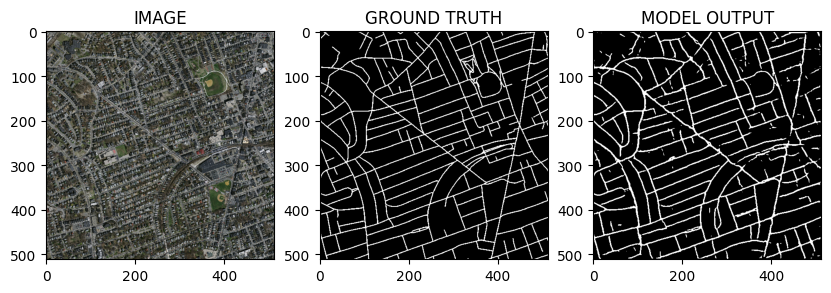

In [93]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))